# MobileNetv2 partially retrained cytopix data

## 2024-08-05



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [4]:
import tensorflow as tf
import keras

print(tf.__version__)
keras.backend.clear_session()

tf.random.set_seed(42)

2024-08-15 10:19:24.783419: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 10:19:24.800179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 10:19:24.823308: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 10:19:24.823363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 10:19:24.839126: I tensorflow/core/platform/cpu_feature_gua

2.16.2


Defining custom functions

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


def get_confusion_matrix(y_test, y_pred, class_names):

    _, ax = plt.subplots(figsize=(8, 8))
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
        display_labels=class_names,
    )

    plt.rc("font", size=12)
    ax.set_title(f"Confusion Matrix")


def plot_history(history, metrics):
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")

Load in model weights

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    BatchNormalization,
    ReLU,
    GlobalAveragePooling2D,
)
from tensorflow.keras.regularizers import L2
from tensorflow.keras.applications import MobileNetV2


mobile_net = keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
)

model = Sequential()

model.add(mobile_net)
mobile_net.trainable = True
model.add(GlobalAveragePooling2D())
model.add(Dense(5, activation="softmax"))

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

2024-08-15 10:19:27.519813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

EPOCHS = 200

earlystopper = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)


def learning_rate_schedule(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return (lr * tf.math.exp(-0.1)).numpy()


lr_scheduler = LearningRateScheduler(learning_rate_schedule)

Loading ImageStream dataset

Checking if train_ds distribution is comparable to total images in folder for the ImageStream dataset

discocyte : 0.41099904593157965
granular : 0.3001226659397574
holly_leaf : 0.09029576121030394
echinocyte : 0.14549543410113125
sickle : 0.05308709281722775


<Axes: >

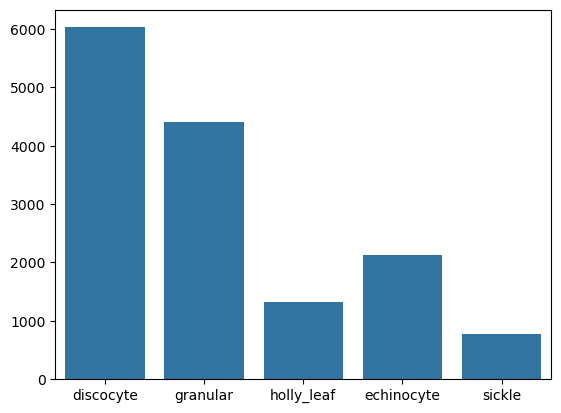

In [ ]:
from collections import Counter


def calculate_class_distribution(ds):
    class_counts = Counter()
    y_train = [y.numpy().item() for _, y in ds]

    for my_class in y_train:
        class_counts[my_class] += 1

    class_counts = {ds.class_names[key]: value for key, value in class_counts.items()}

    total = sum(class_counts.values())
    class_ratios = {k: v / total for k, v in class_counts.items()}
    return (class_counts, class_ratios)


counts = {
    "discocyte": 6031,
    "granular": 4404,
    "holly_leaf": 1325,
    "echinocyte": 2135,
    "sickle": 779,
}  # distribution of the cell types in the dataset in folder

gen_total = sum(counts.values())

for my_class, count in counts.items():
    print(my_class, ":", count / gen_total)
sns.barplot(counts)

The dataset is highly unbalanced, here I use rejection resampling in the data augmentation pipeline to bring it to equal class distribution.

In [ ]:
path_in = "/home/t.afanasyeva/deep_learning_anaemias/resources/imagestream"

In [12]:
from keras.layers import (
    Rescaling,
    RandomFlip,
    RandomRotation,
    RandomTranslation,
    RandomContrast,
    RandomBrightness,
)

AUTOTUNE = tf.data.AUTOTUNE

rescale = tf.keras.Sequential([Rescaling(1.0 / 255)])
data_augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        RandomTranslation(0.2, 0.2),
        RandomContrast(0.2),
        RandomBrightness(0.2),
    ]
)


def prepare(ds, batch_size, initial_dist=None, target_dist=None, augment=False):

    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

    if augment:

        # Correct imbalance in class distribution
        ds = ds.rejection_resample(
            class_func=lambda x, y: y,
            initial_dist=initial_dist,
            target_dist=target_dist,
            seed=93,
        )

        # Flatten rejection resampling outputs ((class_func_results, x), y)
        ds = ds.map(lambda _, data: data)

        # Add augmentation to images
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )

    ds = ds.batch(batch_size, num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
IMG_SIZE = (96, 96)
BATCH_SIZE = 24

train_ds, test_ds = keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="int",
    class_names=["discocyte", "granular", "holly_leaf", "sickle", "echinocyte"],
    color_mode="rgb",
    batch_size=None,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=93,
    validation_split=0.2,
    subset="both",
    data_format="channels_last",
    verbose=True,
)

class_names = test_ds.class_names

_, prior_distribution = calculate_class_distribution(train_ds)
initial_dist = list(prior_distribution.values())
target_dist = [0.2, 0.2, 0.2, 0.2, 0.2]

steps_per_epoch = len(train_ds) // BATCH_SIZE
validation_steps = len(test_ds) // BATCH_SIZE

train_ds = prepare(
    train_ds,
    target_dist=target_dist,
    initial_dist=initial_dist,
    batch_size=BATCH_SIZE,
    augment=True,
)

test_ds = prepare(
    test_ds,
    batch_size=BATCH_SIZE,
)

Found 14674 files belonging to 5 classes.
Using 11740 files for training.
Using 2934 files for validation.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



2024-08-15 10:19:56.527088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
with tf.device("GPU:0"):
    history = model.fit(
        train_ds.repeat(),
        validation_data=test_ds.repeat(),
        callbacks=[earlystopper, lr_scheduler],
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        validation_freq=2,
    )

Epoch 1/200


Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.2727483

  1/489 ━━━━━━━━━━━━━━━━━━━━ 10:16:45 76s/step - accuracy: 0.0000e+00 - loss: 2.6009

I0000 00:00:1723710073.077364 3668543 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


489/489 ━━━━━━━━━━━━━━━━━━━━ 156s 164ms/step - accuracy: 0.4818 - loss: 1.3021 - learning_rate: 0.0010
Epoch 2/200
  3/489 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.5718 - loss: 0.9270

/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


489/489 ━━━━━━━━━━━━━━━━━━━━ 100s 204ms/step - accuracy: 0.5258 - loss: 1.0743 - val_accuracy: 0.4686 - val_loss: 1.5313 - learning_rate: 0.0010
Epoch 3/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 74s 151ms/step - accuracy: 0.5970 - loss: 0.9286 - learning_rate: 0.0010
Epoch 4/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 89s 183ms/step - accuracy: 0.6059 - loss: 0.8938 - val_accuracy: 0.3062 - val_loss: 2.2302 - learning_rate: 0.0010
Epoch 5/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 53s 108ms/step - accuracy: 0.5523 - loss: 1.0111 - learning_rate: 0.0010
Epoch 6/200
223/489 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step - accuracy: 0.5904 - loss: 0.9177

I0000 00:00:1723710499.320353 3668542 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_25', 16 bytes spill stores, 16 bytes spill loads



446/489 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.5860 - loss: 0.9348

I0000 00:00:1723710531.425456 3668513 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads



489/489 ━━━━━━━━━━━━━━━━━━━━ 67s 137ms/step - accuracy: 0.5857 - loss: 0.9362 - val_accuracy: 0.6450 - val_loss: 1.4425 - learning_rate: 0.0010
Epoch 7/200
186/489 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.6013 - loss: 0.9098

I0000 00:00:1723710577.330288 3668513 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_18', 16 bytes spill stores, 16 bytes spill loads



489/489 ━━━━━━━━━━━━━━━━━━━━ 91s 187ms/step - accuracy: 0.5916 - loss: 0.9344 - learning_rate: 0.0010
Epoch 8/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.6048 - loss: 0.9076 - val_accuracy: 0.6952 - val_loss: 1.3102 - learning_rate: 0.0010
Epoch 9/200
 93/489 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.5636 - loss: 0.9894

I0000 00:00:1723710661.691632 3668513 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 16 bytes spill stores, 16 bytes spill loads



489/489 ━━━━━━━━━━━━━━━━━━━━ 32s 66ms/step - accuracy: 0.5812 - loss: 0.9487 - learning_rate: 0.0010
Epoch 10/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.5926 - loss: 0.9142 - val_accuracy: 0.7667 - val_loss: 0.9933 - learning_rate: 0.0010
Epoch 11/200
229/489 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.5851 - loss: 0.9388

I0000 00:00:1723710722.993789 3668513 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 16 bytes spill stores, 16 bytes spill loads



489/489 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.5969 - loss: 0.9165 - learning_rate: 0.0010
Epoch 12/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 50s 103ms/step - accuracy: 0.5776 - loss: 0.9478 - val_accuracy: 0.5076 - val_loss: 1.8151 - learning_rate: 0.0010
Epoch 13/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.5844 - loss: 0.9349 - learning_rate: 0.0010
Epoch 14/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 43s 88ms/step - accuracy: 0.5921 - loss: 0.9298 - val_accuracy: 0.7375 - val_loss: 1.2910 - learning_rate: 0.0010
Epoch 15/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 46s 95ms/step - accuracy: 0.5899 - loss: 0.9320 - learning_rate: 0.0010
Epoch 16/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 60s 123ms/step - accuracy: 0.6078 - loss: 0.8854 - val_accuracy: 0.8333 - val_loss: 0.5973 - learning_rate: 9.0484e-04
Epoch 17/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 49s 100ms/step - accuracy: 0.6306 - loss: 0.8344 - learning_rate: 8.1873e-04
Epoch 18/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.6009 - l

I0000 00:00:1723711170.802885 3668543 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads



489/489 ━━━━━━━━━━━━━━━━━━━━ 49s 100ms/step - accuracy: 0.6158 - loss: 0.8662 - val_accuracy: 0.8357 - val_loss: 0.4155 - learning_rate: 4.9659e-04
Epoch 23/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.6112 - loss: 0.8658 - learning_rate: 4.4933e-04
Epoch 24/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.6162 - loss: 0.8606 - val_accuracy: 0.8935 - val_loss: 0.2848 - learning_rate: 4.0657e-04
Epoch 25/200
295/489 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.6232 - loss: 0.8554

I0000 00:00:1723711293.417855 3668458 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_14', 16 bytes spill stores, 16 bytes spill loads



489/489 ━━━━━━━━━━━━━━━━━━━━ 59s 120ms/step - accuracy: 0.6225 - loss: 0.8533 - learning_rate: 3.6788e-04
Epoch 26/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.6244 - loss: 0.8387 - val_accuracy: 0.9230 - val_loss: 0.2051 - learning_rate: 3.3287e-04
Epoch 27/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6286 - loss: 0.8461 - learning_rate: 3.0119e-04
Epoch 28/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6372 - loss: 0.8206 - val_accuracy: 0.9251 - val_loss: 0.2068 - learning_rate: 2.7253e-04
Epoch 29/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6294 - loss: 0.8145 - learning_rate: 2.4660e-04
Epoch 30/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.6469 - loss: 0.7972 - val_accuracy: 0.9086 - val_loss: 0.2575 - learning_rate: 2.2313e-04
Epoch 31/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6155 - loss: 0.8495 - learning_rate: 2.0190e-04
Epoch 32/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - ac

I0000 00:00:1723711487.347907 3668513 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 16 bytes spill stores, 16 bytes spill loads



489/489 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 0.6444 - loss: 0.7998 - val_accuracy: 0.9210 - val_loss: 0.2046 - learning_rate: 1.2246e-04
Epoch 37/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.6394 - loss: 0.8003 - learning_rate: 1.1080e-04
Epoch 38/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.6180 - loss: 0.8549 - val_accuracy: 0.9055 - val_loss: 0.2335 - learning_rate: 1.0026e-04
Epoch 39/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6061 - loss: 0.8706 - learning_rate: 9.0718e-05
Epoch 40/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.6438 - loss: 0.7968 - val_accuracy: 0.9107 - val_loss: 0.2192 - learning_rate: 8.2085e-05
Epoch 41/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6295 - loss: 0.8363 - learning_rate: 7.4273e-05
Epoch 42/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.6485 - loss: 0.7883 - val_accuracy: 0.9189 - val_loss: 0.2025 - learning_rate: 6.7205e-05
Epoch 43/200
489/48

In [ ]:
history.history["val_loss"] = [
    val for val in history.history["val_loss"] for _ in range(2)
]
history.history["val_accuracy"] = [
    val for val in history.history["val_accuracy"] for _ in range(2)
]

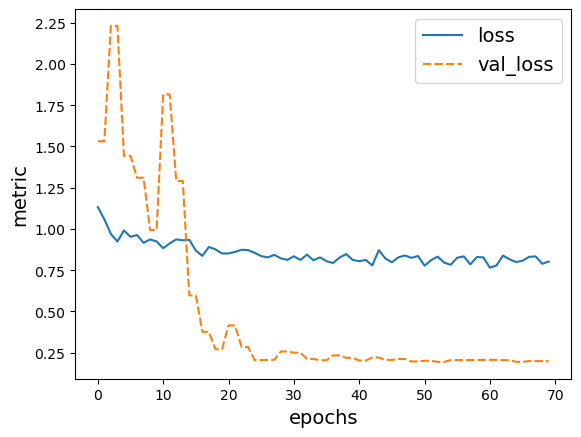

In [52]:
plot_history(history, ["loss", "val_loss"])

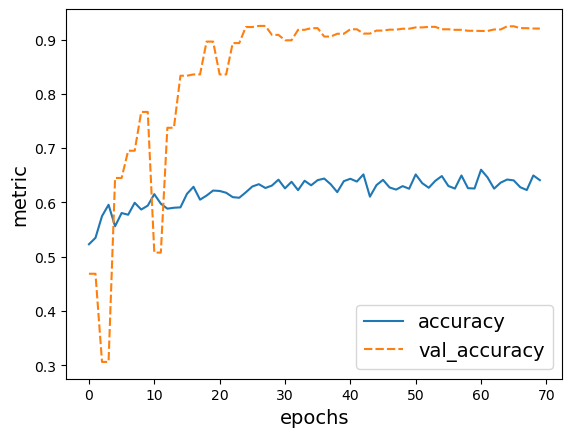

In [53]:
plot_history(history, ["accuracy", "val_accuracy"])

In [54]:
y_test = tf.concat([y for _, y in test_ds], axis=0)
y_train = tf.concat([y for _, y in train_ds], axis=0)
y_pred = model.predict(test_ds)
y_pred = y_pred.argmax(axis=1)

2024-08-15 11:08:42.304175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.53070378

123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step


In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   discocyte       1.00      1.00      1.00      1183
    granular       0.87      0.93      0.90       863
  holly_leaf       0.90      0.63      0.74       280
      sickle       0.73      0.99      0.84       162
  echinocyte       0.94      0.88      0.91       446

    accuracy                           0.92      2934
   macro avg       0.89      0.89      0.88      2934
weighted avg       0.93      0.92      0.92      2934



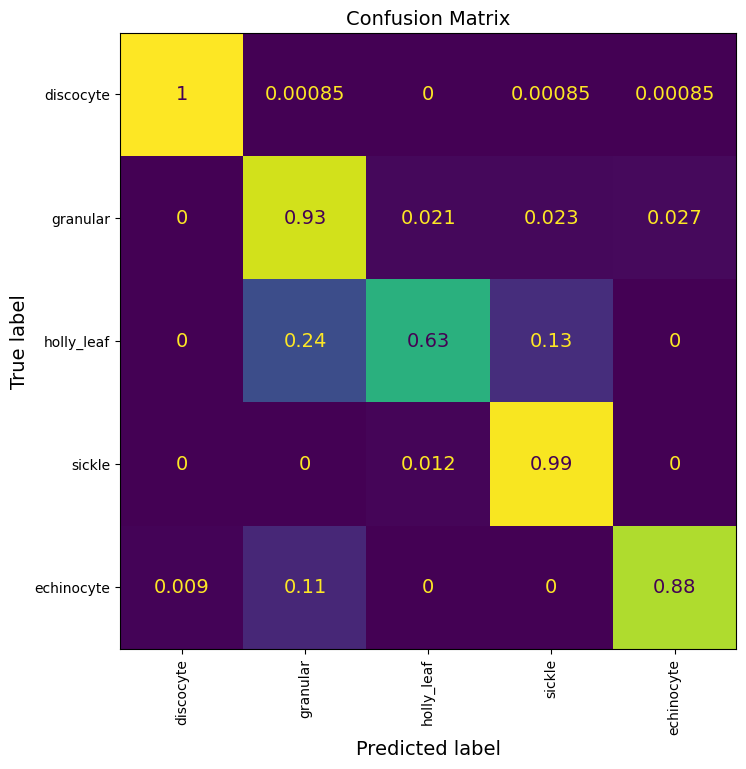

In [56]:
get_confusion_matrix(y_test, y_pred, class_names)

In [ ]:
model.save_weights(
    "/home/t.afanasyeva/deep_learning_anaemias/model_zoo/mobile_net_v03.weights.h5"
)
model.save("/home/t.afanasyeva/deep_learning_anaemias/model_zoo/mobile_net_v03.keras")

Let's see the performance on the Cytpix dataset if we retrain the 50 last layers of the model.

In [ ]:
# model.load_weights("/home/t.afanasyeva/deep_learning_anaemias/model_zoo/mobile_net_v03.weights.h5")

In [59]:
for layer in mobile_net.layers[:-50]:
    print(layer)
    layer.trainable = False

<InputLayer name=input_layer, built=True>
<Conv2D name=Conv1, built=True>
<BatchNormalization name=bn_Conv1, built=True>
<ReLU name=Conv1_relu, built=True>
<DepthwiseConv2D name=expanded_conv_depthwise, built=True>
<BatchNormalization name=expanded_conv_depthwise_BN, built=True>
<ReLU name=expanded_conv_depthwise_relu, built=True>
<Conv2D name=expanded_conv_project, built=True>
<BatchNormalization name=expanded_conv_project_BN, built=True>
<Conv2D name=block_1_expand, built=True>
<BatchNormalization name=block_1_expand_BN, built=True>
<ReLU name=block_1_expand_relu, built=True>
<ZeroPadding2D name=block_1_pad, built=True>
<DepthwiseConv2D name=block_1_depthwise, built=True>
<BatchNormalization name=block_1_depthwise_BN, built=True>
<ReLU name=block_1_depthwise_relu, built=True>
<Conv2D name=block_1_project, built=True>
<BatchNormalization name=block_1_project_BN, built=True>
<Conv2D name=block_2_expand, built=True>
<BatchNormalization name=block_2_expand_BN, built=True>
<ReLU name=bloc

Preparing train and test split of Cytpix data

In [64]:
path_in = "/home/t.afanasyeva/deep_learning_anaemias/resources/training"

In [67]:
cp_train_ds, cp_test_ds = keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="int",
    class_names=["discocyte", "holly_leaf", "granular", "sickle", "echinocyte"],
    color_mode="rgb",
    batch_size=None,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=93,
    validation_split=0.2,
    subset="both",
    data_format="channels_last",
    verbose=True,
)

Found 13571 files belonging to 5 classes.
Using 10857 files for training.
Using 2714 files for validation.


{'discocyte': 0.806023763470572, 'holly_leaf': 0.05572441742654509, 'sickle': 0.03923735838629456, 'granular': 0.07515888366952196, 'echinocyte': 0.02385557704706641}


<Axes: >

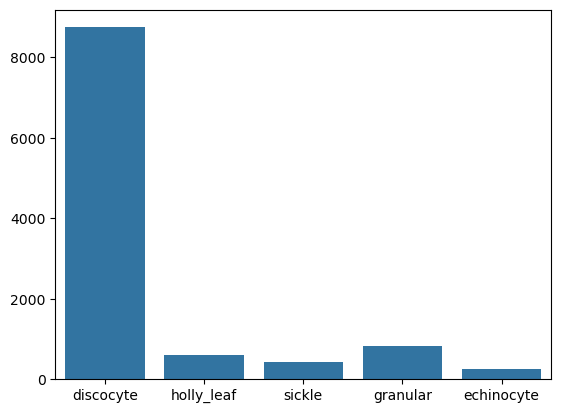

In [ ]:
prior_counts, prior_distribution = calculate_class_distribution(cp_train_ds)
initial_dist = list(prior_distribution.values())
print(prior_distribution)
sns.barplot(prior_counts)

In [70]:
cp_train_ds = prepare(
    cp_train_ds,
    target_dist=target_dist,
    initial_dist=initial_dist,
    batch_size=BATCH_SIZE,
    augment=True,
)
cp_test_ds = prepare(
    cp_test_ds,
    batch_size=BATCH_SIZE,
)

In [71]:
for data, label in cp_train_ds.take(1):
    print(f"Train data shape: {data.shape}, label shape: {label.shape}")

Train data shape: (24, 96, 96, 3), label shape: (24,)


Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.41065

In [72]:
with tf.device("GPU:0"):
    history = model.fit(
        cp_train_ds.repeat(),
        validation_data=cp_test_ds.repeat(),
        callbacks=[earlystopper, lr_scheduler],
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        validation_freq=2,
    )

Epoch 1/200
  1/489 ━━━━━━━━━━━━━━━━━━━━ 2:46 342ms/step - accuracy: 0.1250 - loss: 2.4885

Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.41065

489/489 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.2728 - loss: 2.3907 - learning_rate: 4.0868e-06
Epoch 2/200
  7/489 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2321 - loss: 1.8262

/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


489/489 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.2834 - loss: 1.7738 - val_accuracy: 0.7708 - val_loss: 0.4680 - learning_rate: 4.0868e-06
Epoch 3/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.3061 - loss: 1.6045 - learning_rate: 4.0868e-06
Epoch 4/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.3259 - loss: 1.5262 - val_accuracy: 0.8008 - val_loss: 0.4305 - learning_rate: 4.0868e-06
Epoch 5/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.3586 - loss: 1.4394 - learning_rate: 4.0868e-06
Epoch 6/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.3801 - loss: 1.4145 - val_accuracy: 0.8345 - val_loss: 0.3926 - learning_rate: 4.0868e-06
Epoch 7/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.3890 - loss: 1.3718 - learning_rate: 4.0868e-06
Epoch 8/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.4256 - loss: 1.3267 - val_accuracy: 0.8496 - val_loss: 0.3726 - learning_rate: 4.0868e-06
Epoch 9/200
489/489 ━━━━━

In [73]:
history.history["val_loss"] = [
    val for val in history.history["val_loss"] for _ in range(2)
]
history.history["val_accuracy"] = [
    val for val in history.history["val_accuracy"] for _ in range(2)
]

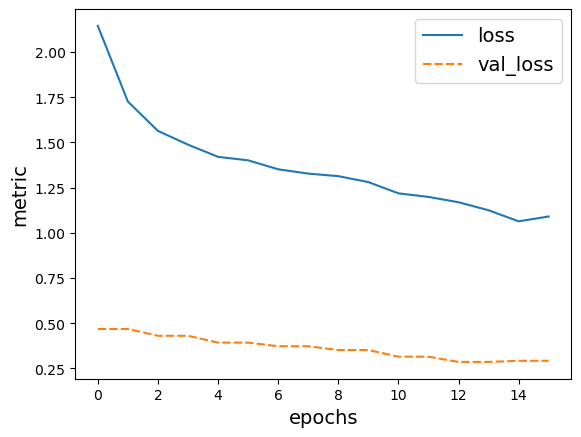

In [74]:
plot_history(history, ["loss", "val_loss"])

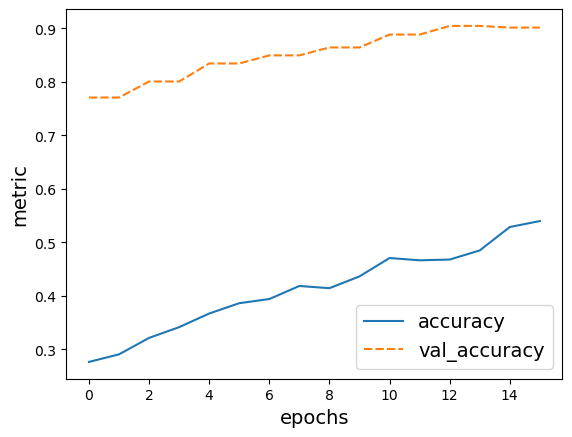

In [75]:
plot_history(history, ["accuracy", "val_accuracy"])

In [77]:
y_test = tf.concat([y for x, y in cp_test_ds], axis=0)
y_pred = model.predict(cp_test_ds)
y_pred = y_pred.argmax(axis=1)

114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


In [81]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   discocyte       0.99      0.90      0.94      2152
    granular       0.21      0.31      0.25       180
  holly_leaf       0.14      0.10      0.11       199
      sickle       0.25      0.75      0.38       112
  echinocyte       0.24      0.06      0.09        71

    accuracy                           0.77      2714
   macro avg       0.36      0.42      0.35      2714
weighted avg       0.82      0.77      0.79      2714



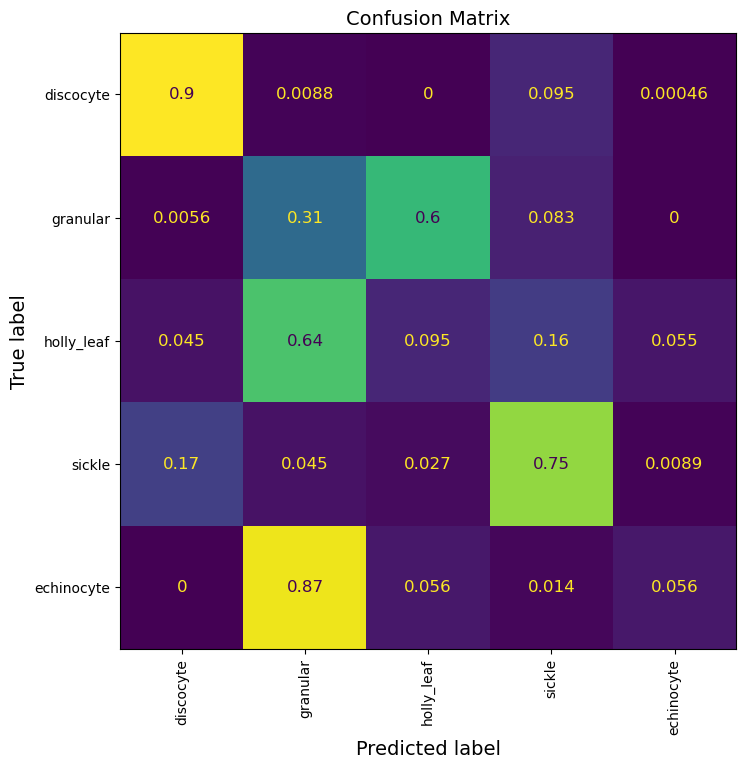

In [82]:
get_confusion_matrix(y_test, y_pred, class_names)

In [ ]:
model.get_layer("mobilenetv2_1.00_96").get_config()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,724,945 (25.65 MB)

 Trainable params: 1,861,509 (7.10 MB)

 Non-trainable params: 402,880 (1.54 MB)

 Optimizer params: 4,460,556 (17.02 MB)

Here, the last 100 layers of the model are re-trained. 

In [145]:
mobile_net = keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
)

model = Sequential()

model.add(mobile_net)

model.add(GlobalAveragePooling2D())
model.add(Dense(5, activation="softmax", name="predictions"))

model.build((None, 96, 96, 3))
model.load_weights(
    "/home/t.afanasyeva/deep_learning_anaemias/model_zoo/mobile_net_v03.weights.h5"
)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 2,230,277 (8.51 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [146]:
for layer in mobile_net.layers[:-100]:
    layer.trainable = False

In [149]:
with tf.device("GPU:0"):
    history = model.fit(
        cp_train_ds.repeat(),
        validation_data=cp_test_ds.repeat(),
        callbacks=[earlystopper, lr_scheduler],
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        validation_freq=2,
    )

Epoch 1/200


Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.41065

489/489 ━━━━━━━━━━━━━━━━━━━━ 122s 180ms/step - accuracy: 0.4902 - loss: 1.2409 - learning_rate: 0.0010
Epoch 2/200
 12/489 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6060 - loss: 0.8507

/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


489/489 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.5785 - loss: 0.9959 - val_accuracy: 0.9085 - val_loss: 0.2653 - learning_rate: 0.0010
Epoch 3/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 50s 102ms/step - accuracy: 0.5968 - loss: 0.9675 - learning_rate: 0.0010
Epoch 4/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.5945 - loss: 0.9837 - val_accuracy: 0.8090 - val_loss: 0.6484 - learning_rate: 0.0010
Epoch 5/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.5903 - loss: 0.9876 - learning_rate: 0.0010
Epoch 6/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5982 - loss: 0.9673 - val_accuracy: 0.8675 - val_loss: 0.4978 - learning_rate: 0.0010
Epoch 7/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.6096 - loss: 0.9576 - learning_rate: 0.0010
Epoch 8/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.6239 - loss: 0.9246 - val_accuracy: 0.9123 - val_loss: 0.2900 - learning_rate: 0.0010
Epoch 9/200
489/489 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/st

In [150]:
history.history["val_loss"] = [
    val for val in history.history["val_loss"] for _ in range(2)
]
history.history["val_accuracy"] = [
    val for val in history.history["val_accuracy"] for _ in range(2)
]

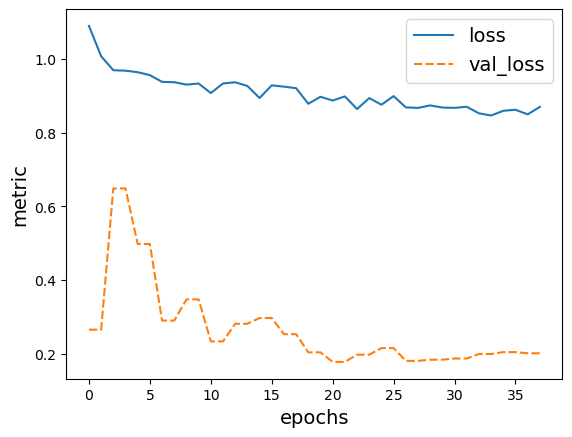

In [151]:
plot_history(history, ["loss", "val_loss"])

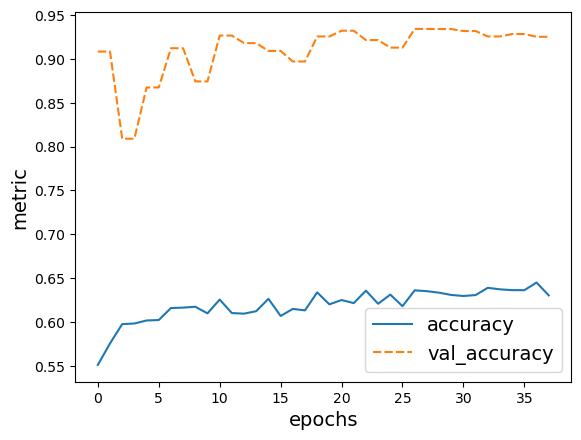

In [152]:
plot_history(history, ["accuracy", "val_accuracy"])

In [158]:
y_test = tf.concat([y for x, y in cp_test_ds], axis=0)
y_pred = model.predict(cp_test_ds)
y_pred = y_pred.argmax(axis=1)

 11/114 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

2024-08-15 16:16:51.244785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [159]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   discocyte       0.99      0.96      0.98      2152
    granular       0.93      0.83      0.88       180
  holly_leaf       0.77      0.84      0.80       199
      sickle       0.59      0.84      0.69       112
  echinocyte       0.59      0.76      0.67        71

    accuracy                           0.93      2714
   macro avg       0.77      0.85      0.80      2714
weighted avg       0.94      0.93      0.94      2714



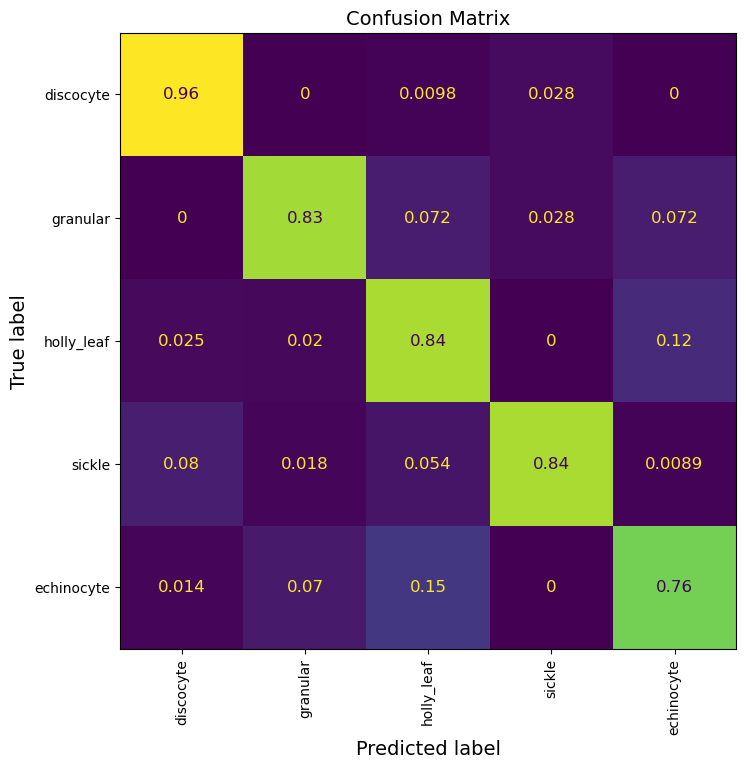

In [160]:
get_confusion_matrix(y_test, y_pred, class_names)

In [161]:
# model.save_weights(
#     "/home/t.afanasyeva/deep_learning_anaemias/model_zoo/mobile_net_v04.weights.h5"
# )

In [162]:
# model.save(
#     "/home/t.afanasyeva/deep_learning_anaemias/model_zoo/mobile_net_v04.keras"
# )